In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import random
import torch.optim as optim
import torch.nn.functional as F
from shutil import copyfile
from torchvision import datasets
from torch.utils.data import DataLoader
import os

In [2]:
if(torch.cuda.is_available()):
    device = torch.device('cuda')
elif(torch.backends.mps.is_available()):
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [3]:
CAT_DIR = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Cat'
DOG_DIR = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages/Dog'

In [4]:
try:
    os.mkdir('/kaggle/working/tmp')
    os.mkdir('/kaggle/working/tmp/cats-v-dogs')
    os.mkdir('/kaggle/working/tmp/cats-v-dogs/training')
    os.mkdir('/kaggle/working/tmp/cats-v-dogs/validation')
    os.mkdir('/kaggle/working/tmp/cats-v-dogs/training/cats')
    os.mkdir('/kaggle/working/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/kaggle/working/tmp/cats-v-dogs/validation/cats')
    os.mkdir('/kaggle/working/tmp/cats-v-dogs/validation/dogs')
except OSError:
    print('Error failed to make directory')

In [5]:
def split_data(main_dir, training_dir, validation_dir, split_size):
    """
    Splits the data into train and test sets

    Args:
    main_dir (string):  path containing the images
    training_dir (string):  path to be used for training
    validation_dir (string):  path to be used for validation
    split_size (float): size of the dataset to be used for training
    """
    files = []
    for file in os.listdir(main_dir):
        if  os.path.getsize(os.path.join(main_dir, file)): # check if the file's size isn't 0
            files.append(file) # appends file name to a list

    shuffled_files = random.sample(files,  len(files)) # shuffles the data
    split = int(0.9 * len(shuffled_files)) #the training split casted into int for numeric rounding
    train = shuffled_files[:split] #training split
    validation = shuffled_files[split:] # validation split

    for element in train:
        copyfile(os.path.join(main_dir,  element), os.path.join(training_dir, element)) # copy files into training directory

    for element in validation:
        copyfile(os.path.join(main_dir,  element), os.path.join(validation_dir, element))# copy files into validation directory
        
split_data(CAT_DIR, '/kaggle/working/tmp/cats-v-dogs/training/cats','/kaggle/working/tmp/cats-v-dogs/validation/cats', 0.9)
split_data(DOG_DIR, '/kaggle/working/tmp/cats-v-dogs/training/dogs', '/kaggle/working/tmp/cats-v-dogs/validation/dogs', 0.9)

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

valid_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [7]:
train_dataset = datasets.ImageFolder('/kaggle/working/tmp/cats-v-dogs/training' , transform=train_transform)
valid_dataset = datasets.ImageFolder('/kaggle/working/tmp/cats-v-dogs/validation',transform=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

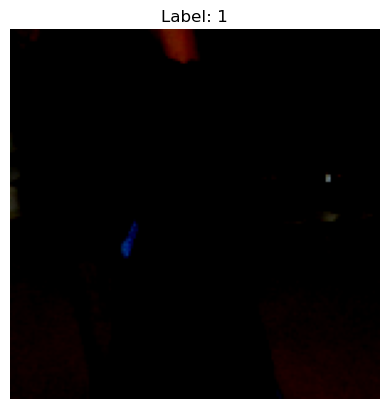

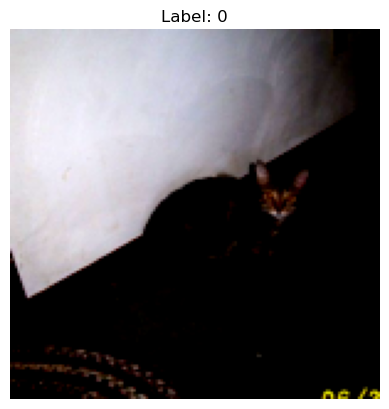

In [8]:
# For train_loader
train_batch = next(iter(train_loader))
images_train, labels_train = train_batch

# For val_loader
val_batch = next(iter(val_loader))
images_val, labels_val = val_batch
# For train_loader
random_index_train = np.random.randint(images_train.size(0))
random_image_train = images_train[random_index_train]
random_label_train = labels_train[random_index_train]

# For val_loader
random_index_val = np.random.randint(images_val.size(0))
random_image_val = images_val[random_index_val]
random_label_val = labels_val[random_index_val]
# For train_loader
random_image_train_np = random_image_train.numpy()
plt.imshow(np.transpose(random_image_train_np, (1, 2, 0)))
plt.title(f"Label: {random_label_train.item()}")
plt.axis('off')
plt.show()

# For val_loader
random_image_val_np = random_image_val.numpy()
plt.imshow(np.transpose(random_image_val_np, (1, 2, 0)))
plt.title(f"Label: {random_label_val.item()}")
plt.axis('off')
plt.show()


In [9]:
data_iter = iter(train_loader)
first_batch = next(data_iter)

print("Training Batch Size = " ,first_batch[0].shape , "| Val Batch Size" , first_batch[1].shape)

Training Batch Size =  torch.Size([64, 3, 150, 150]) | Val Batch Size torch.Size([64])


In [10]:
class Net(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3 , padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding = 1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding = 1)
        self.fc1 = nn.Linear(10368, 512)  
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)
        
        x = self.fc1(x)
        x = self.fc2(x)
        
        x = self.sigmoid(x)
        x = x.reshape(-1)
        
        return x

In [11]:
model = Net()
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [12]:
num_epochs = 30
# Training loop
train_acc = []
train_loss = []
val_acc = []
val_loss = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    model.train()  # Set the model to training mode

    for images, labels in train_loader:
        images = images.to(device)  # Move the input tensor to the GPU
        labels = labels.to(device)  # Move the labels tensor to the GPU

        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        labels = labels.to(torch.float32)

        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    training_loss = running_loss / len(train_loader)
    training_accuracy = 100 * correct_train / total_train

    # Evaluation on test set
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)  # Move the input tensor to the GPU
            labels = labels.to(device)  # Move the labels tensor to the GPU

            outputs = model(images)
            labels = labels.to(torch.float32)

            # Adjust the shape of labels to match the output shape
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Calculate test accuracy
            predicted = torch.round(outputs)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss /= len(val_loader)
    test_accuracy = 100 * correct_test / total_test

    train_acc.append(training_accuracy)
    train_loss.append(training_loss)
    val_acc.append(test_accuracy)
    val_loss.append(test_loss)

    # Print the average loss and accuracy for this epoch
    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: {training_loss:.4f} | Train Accuracy: {training_accuracy:.2f}%")
    print(f"  Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")
    print("*************************")


/opt/conda/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Epoch 1:
  Train Loss: 0.5881 | Train Accuracy: 67.38%
  Test Loss: 0.5283 | Test Accuracy: 74.59%
*************************
Epoch 2:
  Train Loss: 0.4458 | Train Accuracy: 79.06%
  Test Loss: 0.4137 | Test Accuracy: 81.71%
*************************
Epoch 3:
  Train Loss: 0.3528 | Train Accuracy: 84.77%
  Test Loss: 0.3558 | Test Accuracy: 84.15%
*************************
Epoch 4:
  Train Loss: 0.2879 | Train Accuracy: 87.84%
  Test Loss: 0.3246 | Test Accuracy: 85.75%
*************************
Epoch 5:
  Train Loss: 0.2405 | Train Accuracy: 89.96%
  Test Loss: 0.3240 | Test Accuracy: 86.03%
*************************
Epoch 6:
  Train Loss: 0.2060 | Train Accuracy: 91.59%
  Test Loss: 0.3160 | Test Accuracy: 87.84%
*************************
Epoch 7:
  Train Loss: 0.1753 | Train Accuracy: 92.77%
  Test Loss: 0.3477 | Test Accuracy: 87.43%
*************************
Epoch 8:
  Train Loss: 0.1437 | Train Accuracy: 94.23%
  Test Loss: 0.3329 | Test Accuracy: 88.96%
*************************


In [13]:
final_state = model.state_dict()
torch.save(final_state, 'model_state.pth')

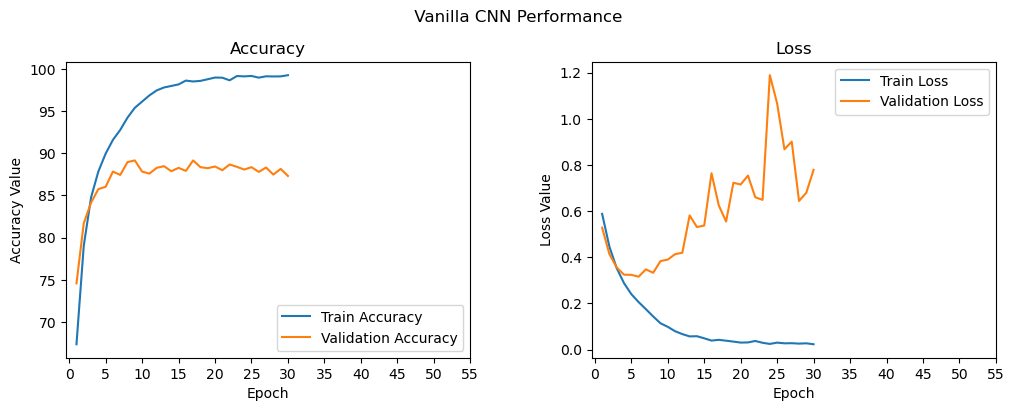

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle(' Vanilla CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,num_epochs+1))
ax1.plot(epoch_list, train_acc, label='Train Accuracy')
ax1.plot(epoch_list, val_acc, label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 60, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, train_loss, label='Train Loss')
ax2.plot(epoch_list, val_loss, label='Validation Loss')
ax2.set_xticks(np.arange(0, 60, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")